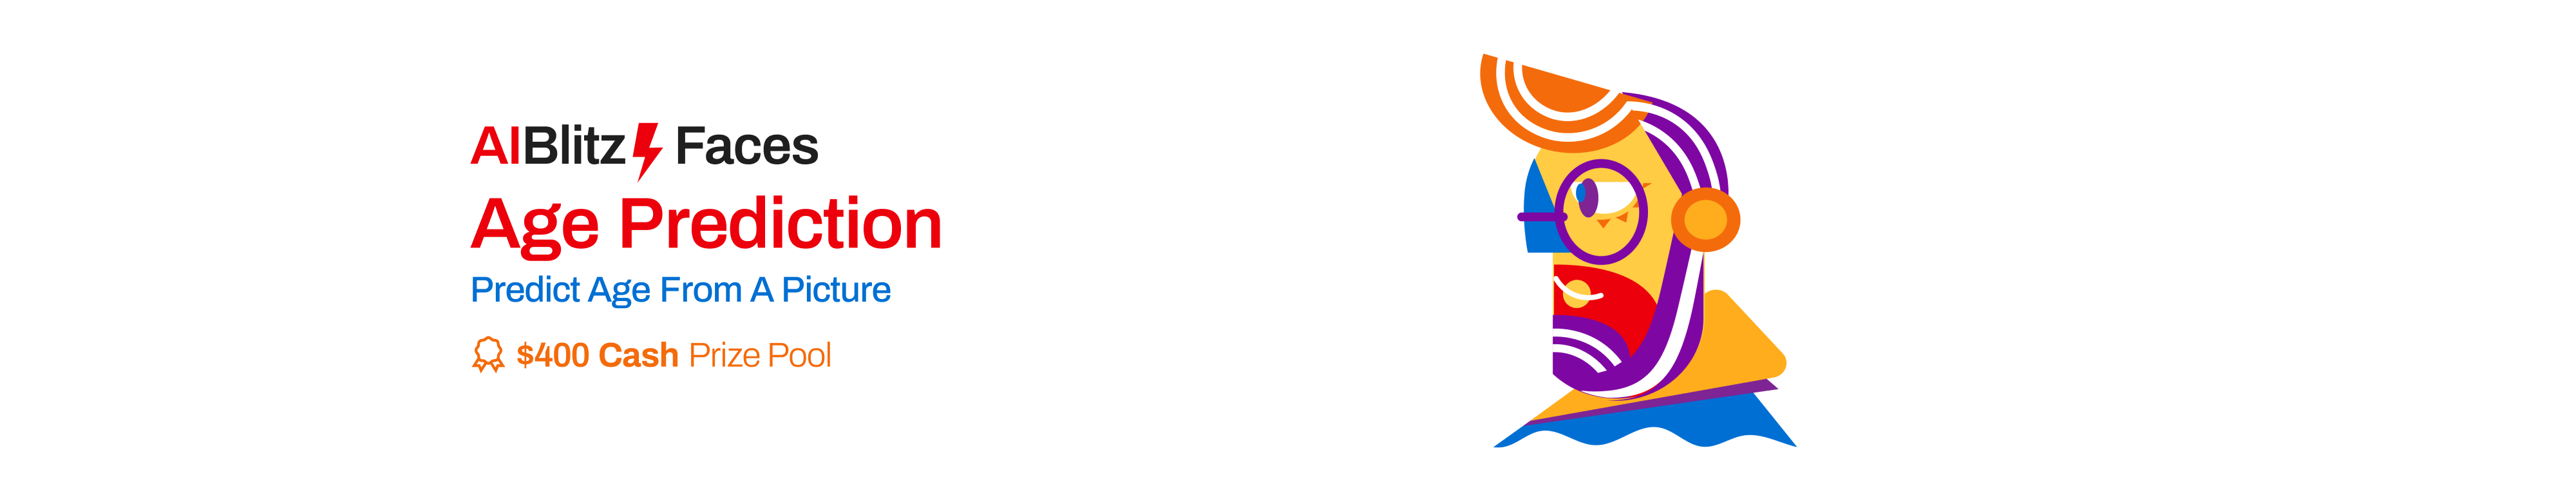

<h2><center> Getting Started with Age Prediction</center></h2>

In this puzzle, we have to predict the age from the given human faces.

This is a starter kit explaining how to download the data and also submit direcly via this notebook. 

We will be the sample submission file directly in the required format. 





# Download the files 💾¶
## Download AIcrowd CLI

We will first install aicrowd-cli which will help you download and later make submission directly via the notebook.


In [ ]:
!pip install aicrowd-cli
%load_ext aicrowd.magic


## Login to AIcrowd ㊗¶


In [ ]:
%aicrowd login

Please login here: https://api.aicrowd.com/auth/vgS5RitUKvanV8sOpJyFXBEt94ieDhcYsdwFcf0f5mY
API Key valid
Gitlab access token valid
Saved details successfully!



## Download Dataset¶

We will create a folder name data and download the files there.


In [ ]:
!rm -rf data
!mkdir data
%aicrowd ds dl -c age-prediction -o data

sample_submission.csv:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

test.csv:   0%|          | 0.00/36.0k [00:00<?, ?B/s]

test.zip:   0%|          | 0.00/176M [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/48.3k [00:00<?, ?B/s]

train.zip:   0%|          | 0.00/236M [00:00<?, ?B/s]

val.csv:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

val.zip:   0%|          | 0.00/117M [00:00<?, ?B/s]

In [ ]:
!unzip data/train.zip -d data/train > /dev/null
!unzip data/val.zip -d data/val > /dev/null
!unzip data/test.zip -d data/test > /dev/null

## Importing Libraries:

In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 14.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from IPython.display import Image
%matplotlib inline
import tensorflow_addons as tfa
from PIL import Image

## Diving in the dataset 🕵️‍♂️

[reference 1](https://sanjayasubedi.com.np/deeplearning/multioutput-keras/)

[reference 2](https://github.com/jangedoo/age-gender-race-prediction)

In [ ]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

In [ ]:
train_df.head()

,ImageID,age
0,93vu1,30-40
1,yjifi,80-90
2,ldd2k,90-100
3,eiwe0,40-50
4,sc0bp,0-10


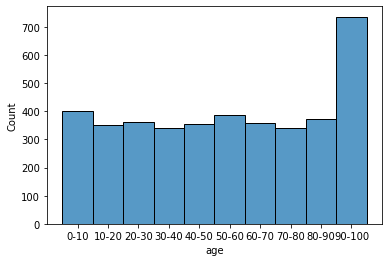

In [ ]:
train_df = train_df.sort_values(by = ['age'])
sns.histplot(train_df['age'])

As we can see that there are 10 different time range in this dataframe.

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((4000, 2), (2000, 2), (3000, 2))

# 2. Preparation

## 2.0 Global Constant

In [ ]:
train_path = '/content/data/train'
test_path = '/content/data/test'
val_path = '/content/data/val'

train_test_prop = 0.3
wid = height = 200

In [ ]:
# prepare the map to tranlate the label with a index
age_map = {}
for i in list(train_df['age'].unique()):
  age_map[i] = int(i[0])
age_map

{'0-10': 0,
 '10-20': 1,
 '20-30': 2,
 '30-40': 3,
 '40-50': 4,
 '50-60': 5,
 '60-70': 6,
 '70-80': 7,
 '80-90': 8,
 '90-100': 9}

In [ ]:
len(age_map)

10

## 2.1 Load the pictures

In [ ]:
def get_data_generator(df, path, indices, for_training, batch_size):

  images, ages = [], []
  while True:
    for i in indices:
      r = df.iloc[i]
      file, age = r['ImageID'], r['age']
      im = Image.open(os.path.join(path, file + '.jpg'))
      im = im.resize((wid, height))
      im = np.array(im)/ 255.0

      images.append(im)
      # change the sparse category to a list 
      ages.append(keras.utils.to_categorical(age_map[age], len(age_map)))

      if len(images) >= batch_size:
        yield np.array(images), (np.array(ages))
        images, ages = [], []
    if not for_training:
      break

In [ ]:
# define the index for train and test spilt for the train 
np.random.seed(1234)
total_idx = np.arange(train_df.shape[0])
np.random.shuffle(total_idx)
train_size = int(train_test_prop * train_df.shape[0])

# seperate train and test
train_train_idx = total_idx[:train_size]
train_test_idx = total_idx[train_size:]

In [ ]:
# prepare the dataset for training
batch_size = 32
train_set = get_data_generator(train_df
                               , train_path
                               , train_train_idx
                               , for_training = True
                               , batch_size=batch_size)
val_set = get_data_generator(train_df
                             , train_path
                             , train_test_idx
                             , for_training = True
                             , batch_size=batch_size)

In [ ]:
# prepare the dataset for validation using for model comparison
val_batch = 128 
val_index = list(range(val_df.shape[0]))

val_comp_set = get_data_generator(val_df
                                  , val_path
                                  , val_index
                                  , for_training = False
                                  , batch_size = val_batch)

In [ ]:
a, b = next(train_set)
b.shape

(32, 10)

In [ ]:
keras.utils.to_categorical(age_map['0-10'], len(age_map))

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

# Train

## 3.1 CNN from Draft

In [ ]:
!nvidia-smi

Thu Feb 17 02:54:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    37W / 250W |   8781MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters = 64, kernel_size=7
                        , activation = 'relu'
                        , padding = 'same'
                        , kernel_initializer = 'he_normal'
                        , input_shape = (wid, height, 3)),
    keras.layers.Conv2D(filters = 128, kernel_size=3
                        , activation = 'relu'
                        , padding = 'same'
                        , kernel_initializer = 'he_normal'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters = 192, kernel_size=3
                        , activation = 'relu'
                        , padding = 'same'
                        , kernel_initializer = 'he_normal'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters = 256, kernel_size=3
                        , activation = 'relu'
                        , padding = 'same'
                        , kernel_initializer = 'he_normal'),
    keras.layers.MaxPooling2D(2),
    keras.layers.BatchNormalization(),

    keras.layers.Flatten(),
    
    keras.layers.Dense(128
                       , kernel_initializer = 'he_normal'
                       , activation = 'sigmoid'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64
                       , kernel_initializer = 'he_normal'
                       , activation = 'softmax'), 
    keras.layers.Dropout(0.2),                      
    keras.layers.Dense(10, activation = 'softmax')
])

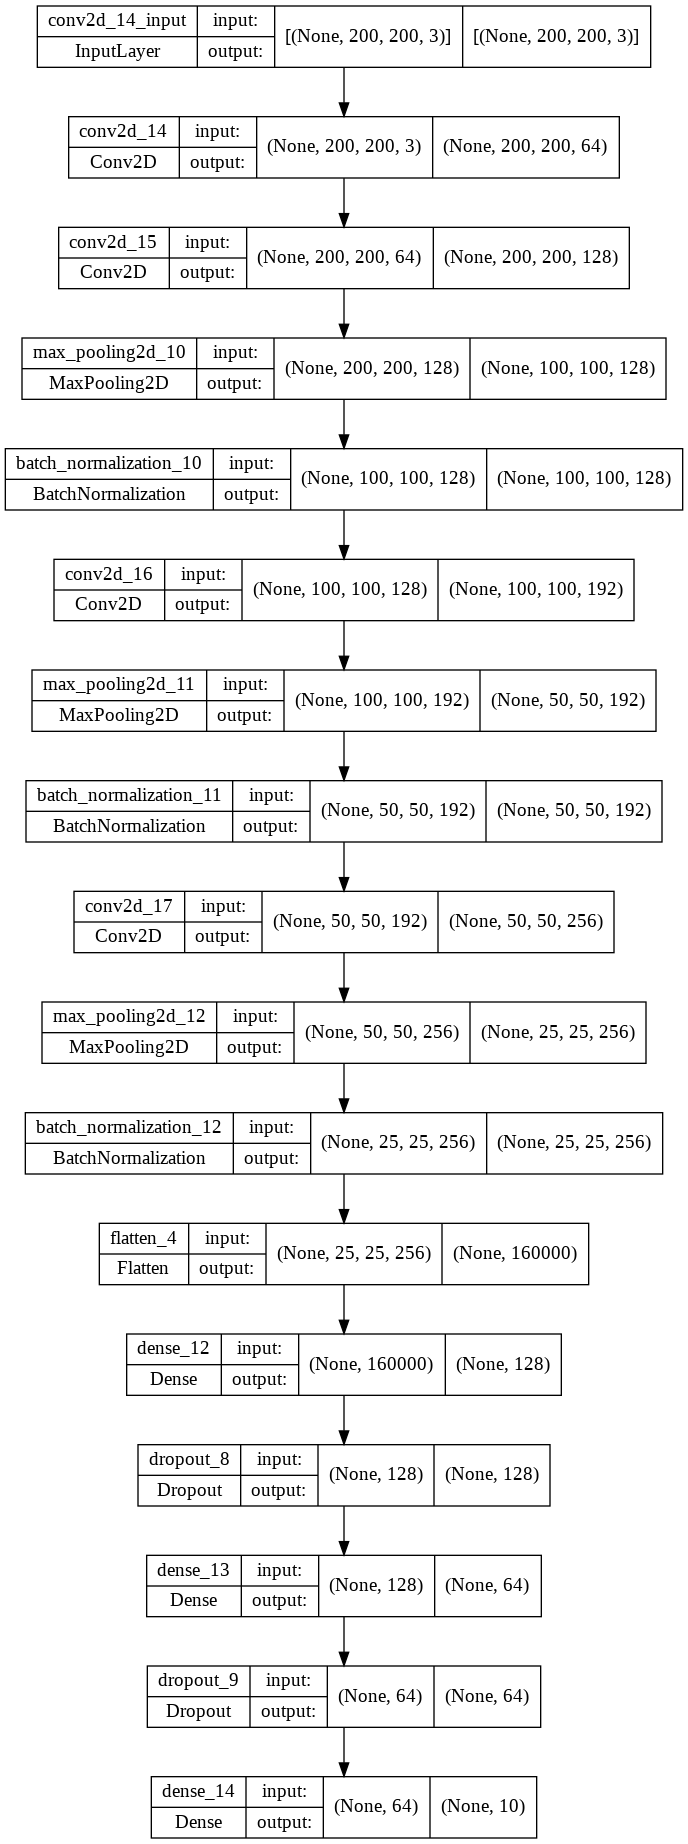

In [ ]:
# print the schema
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [ ]:
metric_f1 = tfa.metrics.F1Score(num_classes=10, threshold=0.5)

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)

opt = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

model.compile(loss = 'categorical_crossentropy'
              , optimizer = opt
              , metrics = [metric_f1, 'accuracy'])

In [ ]:
hist1 = model.fit(train_set, epochs=50
                  , steps_per_epoch=len(train_train_idx)//batch_size
                  , validation_data= val_set
                  , callbacks=[early_stopping_cb]
                  , validation_steps=len(train_test_idx)//batch_size)

Epoch 1/50
37/37 [==============================] - 33s 903ms/step - loss: 1.4840 - f1_score: 0.0720 - accuracy: 0.4198 - val_loss: 1.7173 - val_f1_score: 0.0860 - val_accuracy: 0.3628
Epoch 2/50
37/37 [==============================] - 33s 899ms/step - loss: 1.4166 - f1_score: 0.0711 - accuracy: 0.4265 - val_loss: 1.7013 - val_f1_score: 0.0851 - val_accuracy: 0.3667
Epoch 3/50
37/37 [==============================] - 32s 895ms/step - loss: 1.4132 - f1_score: 0.0697 - accuracy: 0.4324 - val_loss: 1.6483 - val_f1_score: 0.0822 - val_accuracy: 0.3710
Epoch 4/50
37/37 [==============================] - 32s 898ms/step - loss: 1.3620 - f1_score: 0.0715 - accuracy: 0.4409 - val_loss: 1.5915 - val_f1_score: 0.0856 - val_accuracy: 0.4023
Epoch 5/50
37/37 [==============================] - 32s 896ms/step - loss: 1.3640 - f1_score: 0.0701 - accuracy: 0.4350 - val_loss: 1.7250 - val_f1_score: 0.0805 - val_accuracy: 0.3552
Epoch 6/50
37/37 [==============================] - 33s 902ms/step - loss: 

## 3.2 CNN from VGG16

We train the model from the output of vgg

In [ ]:
# load the VGG16 network, ensuring the head FC layers are left off
vgg = keras.applications.VGG16(weights="imagenet", 
                               include_top=False,
                               input_tensor=keras.layers.Input(shape=(wid, height, 3)))

# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False

# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = keras.layers.Flatten()(flatten)

In [ ]:
# apply layers on the vgg results
age_addon = keras.layers.Dense(512, activation = 'relu', 
                               kernel_initializer = 'he_normal')(flatten)
age_addon = keras.layers.Dropout(0.5)(age_addon)
age_addon = keras.layers.Dense(64, activation = 'relu', 
                               kernel_initializer = 'he_normal')(age_addon)
age_addon = keras.layers.Dropout(0.5)(age_addon)
age_addon = keras.layers.Dense(10, activation = 'softmax', 
                               kernel_initializer = 'he_normal', 
                               name = 'age_final_layer')(age_addon)

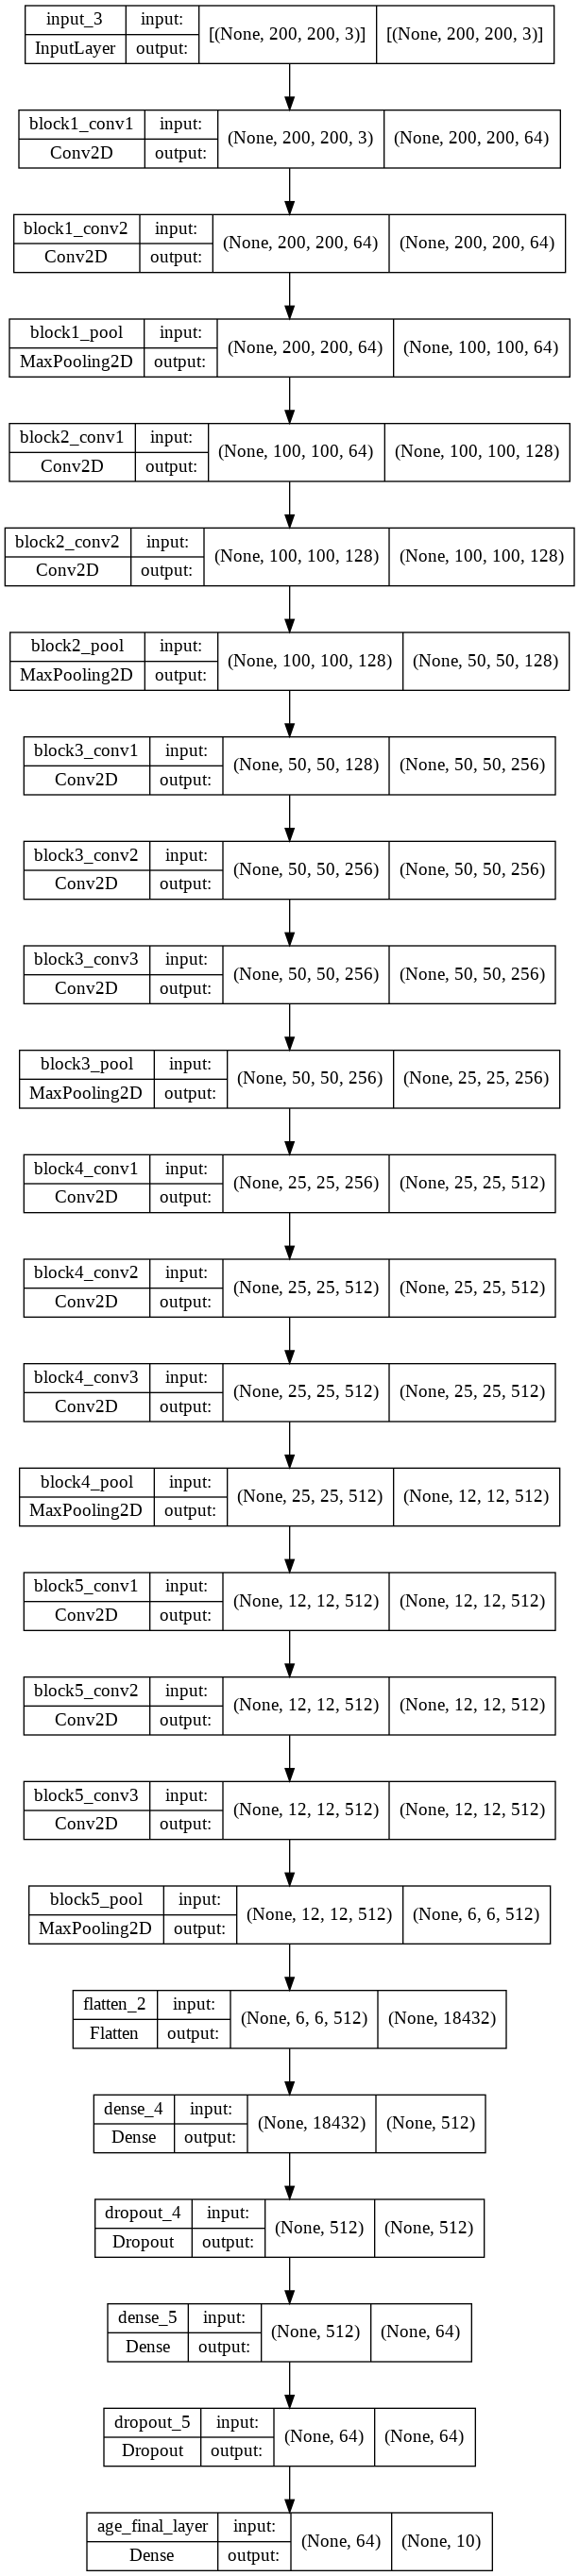

In [ ]:
model2 = keras.models.Model(inputs = vgg.input,
                            outputs = (age_addon))
keras.utils.plot_model(model2, show_shapes = True)

In [ ]:
# define optimizers and other configurations
loss = 'categorical_crossentropy'
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
metric_f1 = tfa.metrics.F1Score(num_classes=10, threshold=0.5)

# apply on the model
model2.compile(loss = loss
              , optimizer = opt
              , metrics = [metric_f1, 'accuracy'])

In [ ]:
hist1 = model2.fit(train_set, epochs=20
                  , steps_per_epoch=len(train_train_idx)//batch_size
                  , validation_data= val_set
                  , callbacks=[early_stopping_cb]
                  , validation_steps=len(train_test_idx)//batch_size)

Epoch 1/20
37/37 [==============================] - 34s 923ms/step - loss: 2.5220 - f1_score: 0.0063 - accuracy: 0.1157 - val_loss: 2.2758 - val_f1_score: 0.0000e+00 - val_accuracy: 0.1821
Epoch 2/20
37/37 [==============================] - 33s 910ms/step - loss: 2.3710 - f1_score: 8.9686e-04 - accuracy: 0.1191 - val_loss: 2.2791 - val_f1_score: 0.0000e+00 - val_accuracy: 0.1828
Epoch 3/20
37/37 [==============================] - 33s 919ms/step - loss: 2.3278 - f1_score: 0.0000e+00 - accuracy: 0.1571 - val_loss: 2.2745 - val_f1_score: 0.0000e+00 - val_accuracy: 0.1818
Epoch 4/20
37/37 [==============================] - 33s 918ms/step - loss: 2.2925 - f1_score: 0.0000e+00 - accuracy: 0.1461 - val_loss: 2.2597 - val_f1_score: 0.0000e+00 - val_accuracy: 0.1814
Epoch 5/20
37/37 [==============================] - 33s 914ms/step - loss: 2.2783 - f1_score: 0.0018 - accuracy: 0.1765 - val_loss: 2.2462 - val_f1_score: 0.0000e+00 - val_accuracy: 0.1825
Epoch 6/20
37/37 [=========================

## Generating Prediction File

In this starter kit we will directly be submitting the sample prediction file. In case you would like to see a submission via baseline model, check it out here. 

In [ ]:
age_key = list(age_map.keys())
age_key.sort()

In [ ]:
def get_test_result(df_original, path, key_list, model):

  df = df_original.copy()

  label = []
  for idx, r in df.iterrows():
    
    file = r['ImageID']
    im = Image.open(os.path.join(path, file + '.jpg'))
    im = im.resize((wid, height))
    im = np.array(im)/ 255.0
    im = im[np.newaxis, ...]

    result = model.predict(im)
    label.append(key_list[result.argmax()])
  
  df['age'] = label
  return df

In [ ]:
test_submit = get_test_result(test_df, test_path, age_key, model)

In [ ]:
im = Image.open('/content/data/test/000e3.jpg')
im = im.resize((wid, height))
im = np.array(im)/ 255.0
im = im[np.newaxis, ...]

In [ ]:
!rm -rf assets
!mkdir assets
test_submit.to_csv(os.path.join("assets", "submission.csv"))


# Submitting our Predictions

Note : Please save the notebook before submitting it (Ctrl + S)


In [ ]:
%aicrowd notebook submit -c age-prediction -a assets --no-verify

Using notebook: AI_Blix13_02_Age_Prediction for submission...
Scrubbing API keys from the notebook...


Output()

╭─────────────────────────╮                                                  
                                                  │ Successfully submitted! │                                                  
                                                  ╰─────────────────────────╯

                                                        Important links                                                        
┌──────────────────┬──────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│  This submission │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/age-prediction/submissions/174146              │
│                  │                                                                                                          │
│  All submissions │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/age-prediction/submissions?my_submissions=true │
│                  │                                                                                                          │
│      Leaderboard │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/age-prediction/leaderboards                    │
│                  │                                                                                                          │
│ Discussion forum │ https://discourse.aicrowd.com/c/ai-blitz-xiii                                                            │
│                  │                                                                                                          │
│   Challenge page │ https://www.aicrowd.com/challenges/ai-blitz-xiii/problems/age-prediction                                 │
└──────────────────┴──────────────────────────────────────────────────────────────────────────────────────────────────────────┘